# Lab Seven: Recurrent Network Architectures

Team: Miro Ronac, Kirk Watson, Brandon Vincitore

Dataset Source: https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset

---
#### For this lab, we will be utilizing a dataset containing tweets about stocks to identify the sentiment of a tweet. Traders can use this classifier to identify the sentiment of the stock market or a stock by evaulating relevant tweets.

In [1]:
%%time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

CPU times: total: 781 ms
Wall time: 961 ms


# 1. Preparation
---
### Reading and cleaning up data
---

<IPython.core.display.Javascript object>


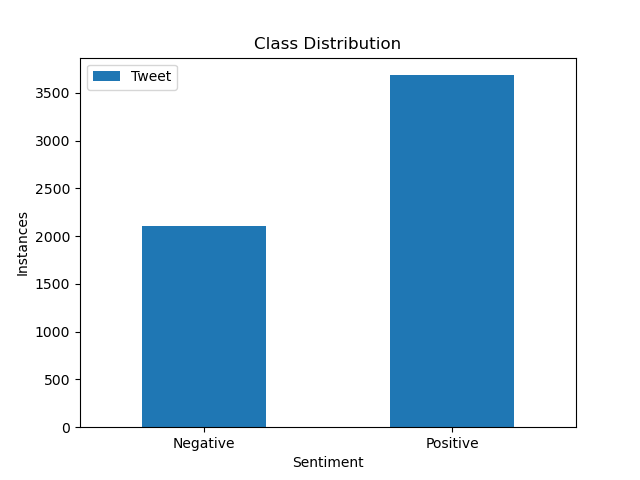

,Tweet,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Positive
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,Positive
2,user I'd be afraid to short AMZN - they are lo...,Positive
3,MNTA Over 12.00,Positive
4,OI Over 21.37,Positive


In [2]:
%matplotlib notebook

df = pd.read_csv('./stock_data.csv')
df = df.rename(columns={'Text': 'Tweet'})

# Drop missing rows
df.dropna(axis=0, inplace=True)

# Checking number of instances in classes
df['Sentiment'] = df['Sentiment'].map({-1:'Negative', 1:'Positive'})
df.groupby('Sentiment').count().plot(kind='bar', rot=0)
plt.ylabel('Instances'); plt.title('Class Distribution')

df.head()

---
##### With the above plot, we see that we are dealing with a slight class imbalance. Let's see the lengths of each text to get an idea of how we should truncate and pad each input sequence.
---

<IPython.core.display.Javascript object>


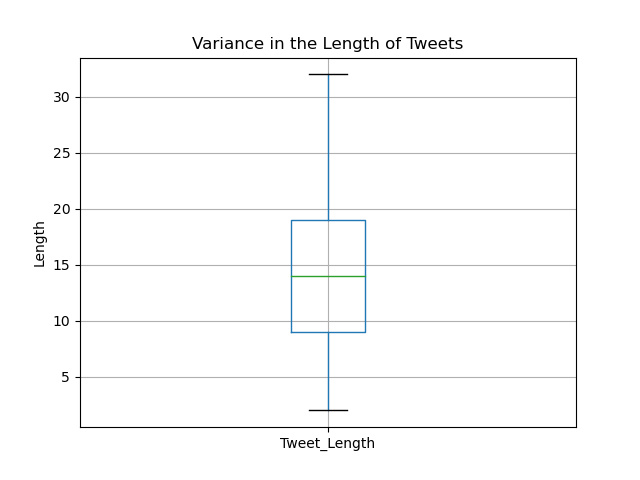

In [3]:
%matplotlib notebook

df['Tweet_Length'] = df.Tweet.str.split().apply(len) # making a column to store text lengths of each input
df.boxplot(column='Tweet_Length')
plt.ylabel('Length'); plt.title('Variance in the Length of Tweets')

df.drop(['Tweet_Length'], axis=1, inplace=True)

---
##### The boxplot above shows that the maximum length of input sequences is capped at 32. The short lengths are expected given the fact that our dataset consists of tweets instead of full blown text documents. We will pad so that all input sequences match the max length of 32. But first, we need a strategy to tokenize each tweet into separate words and from there make sure we extract the most pertinent words to use as input into our model.
---

In [4]:
from tensorflow.keras.preprocessing import sequence
import re
TOKEN_RE = re.compile(r"\w.*?\b")

def get_words(tweet):
    # tokenize the input phrase
    words = [token.casefold() for token in TOKEN_RE.findall(tweet)]
    return words

print('Original tweet: ', df['Tweet'][10])
print('\nTokenized tweet: ', get_words(df['Tweet'][10]))

Original tweet:  i'm assuming FCX opens tomorrow above the 34.25 trigger buy. still very much like this setup.  

Tokenized tweet:  ['i', 'm', 'assuming', 'fcx', 'opens', 'tomorrow', 'above', 'the', '34', '25', 'trigger', 'buy', 'still', 'very', 'much', 'like', 'this', 'setup']


In [5]:
#adapted from in-class example notebook

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df.Tweet
y = df.Sentiment

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TWEET_LEN = 32 # maximum possible words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_TWEET_LEN)

#one hot encode
y[y == "Positive"] = 1
y[y == "Negative"] = 0
y_ohe = keras.utils.to_categorical(y)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 10187 unique tokens. Distilled to 10187 top words.
Shape of data tensor: (5791, 32)
Shape of label tensor: (5791, 2)
10187


##### After tokenizing and saving every unique word, we see that 10187 tokens were found. We set the maximum tweet word length to 32 words to account for the largest tweets in the dataset. For our final dataset, we converted each word to an integer and saved each tweet as a series of integers that represent the correct ordering of words. In addition, the target is one hot encoded for positive and negative tweets.
---
### Evaluation Metric
---
##### We chose to use the F1-score metric to account for the false negatives (recall) and false positives (precision) when evaulating our unbalanced dataset. In the world of stock trading, understanding the sentiment of the market or a stock is important when evaluating a possible trade. We wouldn't want to wrongly evaluate tweets as negative and cause a trader to possibly miss a good buy. In addition, we wouldn't want to wrongly identify tweets as positive causing a trader to make a miscalculated trade. With the F1-score, we have a better metric to minimize both false ocurrences. Furthermore, our dataset is unbalanced in favor of positive tweets. The F1-score suits unbalanced datasets because it is calculated as a harmonic mean of precision and recall.

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K

# F1-score is no longer supported in keras so we must make a F1-score function
# From https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Divide data into training and testing
---
##### To divide our data into training and testing sets, we will use Stratified Shuffle Split. We chose this method because we need to account for the imbalance of negative and positive tweets. We will only use 1 split due time constraints, and we believe that the dataset is large enough to allow for the model to fit without needing multiple folds. The data will be divided into a 80/20 split to give the model plenty of data to train while still having a sufficient amount of data for testing.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(X, y_ohe):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print("Training set size:",X_train.shape[0])
print("Testing set size:",X_test.shape[0])

Training set size: 4632
Testing set size: 1159


# 2. Modeling